## Exploratory Data Analysis (Keystroke Dataset)

In [388]:
from functools import partial
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from sklearn.cluster import SpectralClustering, KMeans, AgglomerativeClustering
from sklearn.metrics import r2_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from scipy import stats
from statsmodels.stats.multitest import multipletests
from tqdm.auto import tqdm
import seaborn as sns

In [389]:
plt.style.use('./plt_style.txt')

In [390]:
with open('large_dataset.pickle', 'rb') as f:
    d = pickle.load(f)
    keystrokes, grades = d['logs'], d['grades']

In [391]:
%matplotlib widget

---

# Analysis

In [205]:
keystrokes.event_type.unique()

array(['text_insert', 'text_remove', 'submit', 'focus_gained',
       'focus_lost', 'run'], dtype=object)

## Keystroke Summary

In [392]:
grades = grades.set_index(['semester', 'class', 'student'])

In [393]:
#keystrokes = keystrokes.sort_values('time_to_deadline', ascending=False)
keystrokes = keystrokes.set_index(['semester', 'class', 'student'])
keystrokes.time_to_deadline = keystrokes.time_to_deadline.dt.total_seconds()

In [394]:
keystrokes

assignment_excercise  time_to_deadline   event_type
semester class student                                                    
2016-1   102   1278                 18_1000       8602089.709  text_insert
               1278                 18_1000       8602088.458  text_remove
               1278                 18_1000       8602088.110  text_insert
               1278                 18_1000       8602055.096  text_insert
               1278                 18_1000       8602055.043  text_insert
...                                     ...               ...          ...
2021-2   357   6216                2808_994       2246907.038  text_insert
               6216                2808_994       2246906.894  text_insert
               6216                2808_994       2246906.694  text_insert
               6216                2808_994       2246905.986  text_insert
               6216                2808_994       2246904.989  text_remove

[3086272 rows x 3 columns]

In [348]:
len(keystrokes.index)

MultiIndex([('2016-1', '102', 1278),
            ('2016-1', '102', 1278),
            ('2016-1', '102', 1278),
            ('2016-1', '102', 1278),
            ('2016-1', '102', 1278),
            ('2016-1', '102', 1278),
            ('2016-1', '102', 1278),
            ('2016-1', '102', 1278),
            ('2016-1', '102', 1278),
            ('2016-1', '102', 1278),
            ...
            ('2021-2', '357', 6193),
            ('2021-2', '357', 6193),
            ('2021-2', '357', 6193),
            ('2021-2', '357', 6193),
            ('2021-2', '357', 6193),
            ('2021-2', '357', 6193),
            ('2021-2', '357', 6193),
            ('2021-2', '357', 6193),
            ('2021-2', '357', 6193),
            ('2021-2', '357', 6193)],
           names=['semester', 'class', 'student'], length=2819432)

In [11]:
keystrokes.groupby(keystrokes.index).count().time_to_deadline.mean()

1032.543325526932

In [12]:
f"Number of student/class: {len(keystrokes.index.unique())}"

'Number of student/class: 2989'

In [13]:
f"Number of events: {len(keystrokes.index)}"

'Number of events: 3086272'

In [14]:
keystrokes.event_type.value_counts()

text_insert     1753827
text_remove      682098
focus_lost       233215
focus_gained     199576
run              111362
submit           106194
Name: event_type, dtype: int64

**TODO:** Can we get paste events from the data as well?

## Grade Distributions

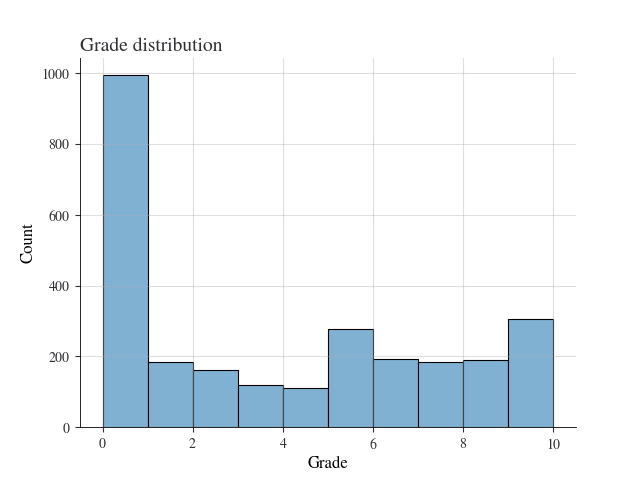

In [15]:
plt.figure()
plt.hist(grades.grade)
plt.grid(alpha=0.4)
plt.xlabel('Grade')
plt.ylabel('Count')
plt.title(f'Grade distribution')
plt.show()

## Summary Features

TODO: I'm not convinced this was correctly adapted from `EDA`, dealing with grouping in deeply nested multindexes is quite difficult.

In [395]:
groups = keystrokes.groupby(['semester', 'class', 'student', keystrokes.assignment_excercise])

In [396]:
time_to_first_event = groups.time_to_deadline.max().unstack(level=-1)

In [397]:
time_to_last_event = groups.time_to_deadline.min().unstack(level=-1)

In [398]:
ks_submits = keystrokes.where(keystrokes.event_type == 'submit')
first_submit = ks_submits.groupby(['semester', 'class', 'student', ks_submits.assignment_excercise]).time_to_deadline.max().unstack(level=-1)

In [399]:
differences = -groups.apply(lambda g: g.sort_values('time_to_deadline', ascending=False).time_to_deadline.diff())

In [400]:
assert (~(differences[~differences.isna()] < 0)).all()

---

In [401]:
all_latencies = differences.groupby('student')

In [402]:
max_latency = differences.quantile(0.995)

In [403]:
filtered_latencies = differences[differences < max_latency]

In [404]:
regrouped = filtered_latencies.groupby(['semester', 'class', 'student'])
mean_latency = regrouped.mean()
fine_time_on_task = regrouped.sum()

---

In [405]:
keystroke_counts = keystrokes.groupby(['semester', 'class', 'student']).event_type.apply(pd.value_counts).unstack(level=-1).fillna(0);

In [406]:
keystrokes.groupby(['semester', 'class', 'student']).event_type.apply(pd.value_counts).unstack(level=-1)

focus_gained  focus_lost    run  submit  text_insert  \
semester class student                                                         
2016-1   102   1278              NaN         NaN    NaN    28.0        448.0   
               1279              9.0         5.0    NaN     7.0        358.0   
               1280              NaN         NaN    NaN    16.0        682.0   
               1281              NaN         NaN    NaN    14.0        617.0   
               1283              NaN         NaN    NaN    13.0        534.0   
...                              ...         ...    ...     ...          ...   
2021-2   357   6038            229.0       342.0  245.0   158.0       3469.0   
               6108             99.0       154.0   87.0     1.0        753.0   
               6141             54.0        86.0   48.0    24.0        308.0   
               6193             69.0        96.0   38.0    14.0       1002.0   
               6216              1.0         NaN    NaN     NaN         30.0   

                        text_remove  
semester class student               
2016-1   102   1278            99.0  
               1279           106.0  
               1280           214.0  
               1281           109.0  
               1283           231.0  
...                             ...  
2021-2   357   6038          2559.0  
               6108           190.0  
               6141           210.0  
               6193           464.0  
               6216             1.0  

[2989 rows x 6 columns]

In [407]:
summary_features = keystroke_counts.assign(
    time_to_last = time_to_last_event.mean(axis=1),
    time_to_first=time_to_first_event.mean(axis=1),
    duration=(time_to_first_event-time_to_last_event).mean(axis=1),
    coarse_time_on_task=(time_to_first_event-first_submit).mean(axis=1),
    fine_time_on_task=fine_time_on_task,
    mean_latency=mean_latency
)
summary_features['coarse_time_on_task']=summary_features['coarse_time_on_task'].fillna(summary_features['coarse_time_on_task'].max()+100)
summary_features['mean_latency'] = summary_features['mean_latency'].fillna(0)
summary_features['fine_time_on_task'] = summary_features['fine_time_on_task'].fillna(0)
summary_features

focus_gained  focus_lost    run  submit  text_insert  \
semester class student                                                         
2016-1   102   1278              0.0         0.0    0.0    28.0        448.0   
               1279              9.0         5.0    0.0     7.0        358.0   
               1280              0.0         0.0    0.0    16.0        682.0   
               1281              0.0         0.0    0.0    14.0        617.0   
               1283              0.0         0.0    0.0    13.0        534.0   
...                              ...         ...    ...     ...          ...   
2021-2   357   6038            229.0       342.0  245.0   158.0       3469.0   
               6108             99.0       154.0   87.0     1.0        753.0   
               6141             54.0        86.0   48.0    24.0        308.0   
               6193             69.0        96.0   38.0    14.0       1002.0   
               6216              1.0         0.0    0.0     0.0         30.0   

                        text_remove  time_to_last  time_to_first  \
semester class student                                             
2016-1   102   1278            99.0  8.600522e+06   8.601953e+06   
               1279           106.0  6.988069e+06   7.390790e+06   
               1280           214.0  8.599192e+06   8.600450e+06   
               1281           109.0  8.597850e+06   8.598177e+06   
               1283           231.0  8.597969e+06   8.598170e+06   
...                             ...           ...            ...   
2021-2   357   6038          2559.0  4.375141e+06   4.777416e+06   
               6108           190.0  2.492641e+06   2.977883e+06   
               6141           210.0  3.937940e+06   3.942484e+06   
               6193           464.0  2.312932e+06   2.313388e+06   
               6216             1.0  2.246905e+06   2.246918e+06   

                             duration  coarse_time_on_task  fine_time_on_task  \
semester class student                                                          
2016-1   102   1278       1430.688571         1.495457e+02           7491.842   
               1279     402721.182500         4.027188e+05           1190.843   
               1280       1258.210429         3.489247e+02           3076.582   
               1281        327.293286         2.660076e+02           2291.053   
               1283        200.720857         1.844351e+02           1405.046   
...                               ...                  ...                ...   
2021-2   357   6038     402275.582000         1.205623e+05          42800.804   
               6108     485242.223300         5.167503e+04           9683.282   
               6141       4544.345857         5.444286e+02          11476.600   
               6193        455.577600         3.841212e+02           6833.664   
               6216         13.493000         3.645417e+06             13.493   

                        mean_latency  
semester class student                
2016-1   102   1278        13.213125  
               1279         2.491303  
               1280         3.407068  
               1281         3.125584  
               1283         1.822368  
...                              ...  
2021-2   357   6038         6.159275  
               6108         7.624631  
               6141        16.006416  
               6193         4.096921  
               6216         0.435258  

[2989 rows x 12 columns]

In [408]:
grades = grades[grades.index.isin(summary_features.index)]

## Keystroke Clustering

In [92]:
@interact(clustering=[AgglomerativeClustering, SpectralClustering, partial(KMeans, random_state=42)], n_clusters=3)
def cluster(clustering, n_clusters):
    clf = clustering()
    predictions = clf.fit_predict(summary_features)
    
    # Boxplot
    plt.clf()
    plt.boxplot([grades.grade[predictions==i] for i in range(n_clusters)])
    plt.xlabel("Cluster")
    plt.ylabel("Exam 3 grade")
    plt.show()

interactive(children=(Dropdown(description='clustering', options=(<class 'sklearn.cluster._agglomerative.Agglo…

## Dimensionality Reduction

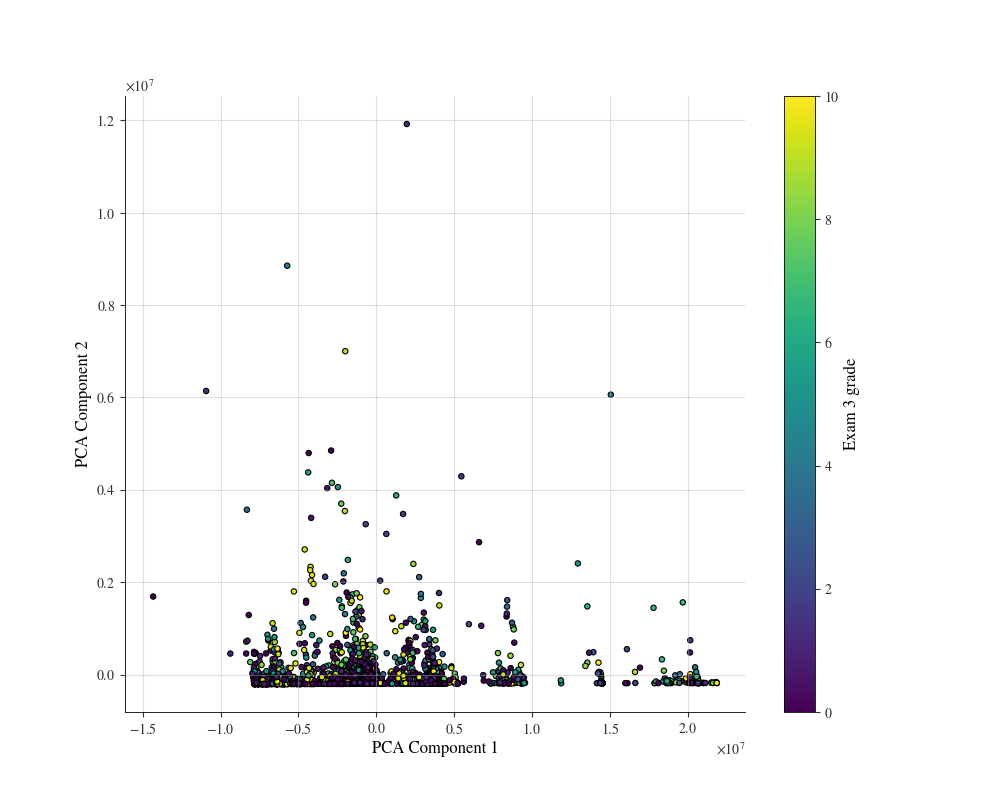

In [30]:
pca = PCA(n_components=2, random_state=42)
reduced_pca = pca.fit_transform(summary_features)
plt.figure(figsize=(10,8))
plt.grid(alpha=0.4)
plt.scatter(reduced_pca[:,0], reduced_pca[:,1], c=grades.grade, s=15)
plt.colorbar(label="Exam 3 grade")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2");

AttributeError: 'DataFrame' object has no attribute 'exam3'

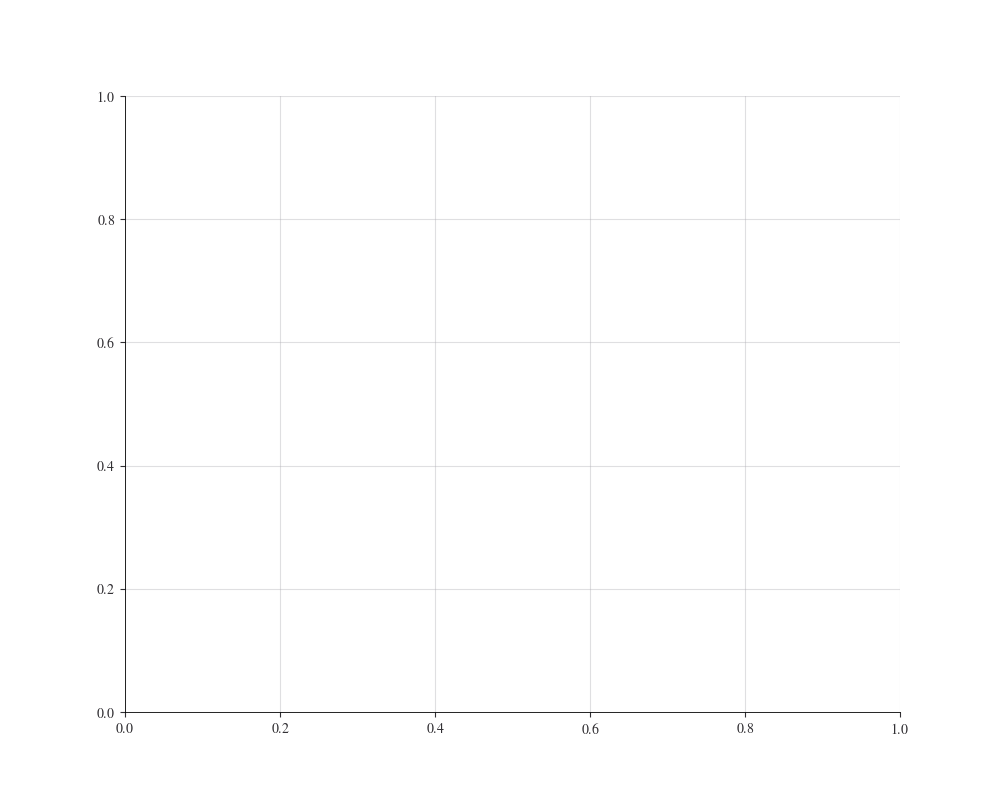

In [95]:
mds = MDS(n_components=2, random_state=42)
reduced_mds = mds.fit_transform(summary_features)
plt.figure(figsize=(10,8))
plt.grid(alpha=0.4)
plt.scatter(reduced_mds[:,0], reduced_mds[:,1], c=grades.grade, s=15)
#plt.colorbar(label="Exam 3 grade")
plt.xlabel("MDS Component 1")
plt.ylabel("MDS Component 2")

## Correlations

### Per class

In [409]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)

In [356]:
per_class_correlations.

,focus_gained,focus_lost,run,submit,text_insert,text_remove,time_to_last,time_to_first,duration,coarse_time_on_task,fine_time_on_task,mean_latency,final
"(2016-1, 102)",-0.413823,-0.465222,-0.275449,-0.120335,-0.044433,-0.213752,0.477671,0.447290,-0.209096,-0.401898,-0.151714,-0.087370,1.0
"(2016-1, 103)",-0.147333,-0.133807,-0.125000,0.153937,0.224425,0.074244,0.255763,0.230344,-0.094052,-0.132161,0.016079,-0.002341,1.0
"(2016-1, 105)",0.105261,0.119013,NaN,0.031990,-0.036374,0.025371,0.287359,0.347250,0.088454,-0.231819,-0.113288,-0.216866,1.0
"(2016-1, 106)",-0.009615,-0.036582,0.146447,-0.265898,-0.115025,-0.094947,-0.058978,-0.150588,-0.105008,0.079684,-0.118965,-0.003650,1.0
"(2016-1, 107)",-0.063564,-0.030591,NaN,0.199749,0.032875,-0.000609,0.132592,0.157712,0.009245,-0.431945,0.039602,0.145050,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2021-2, 353)",0.042788,0.000827,0.083133,-0.092045,0.230778,0.047391,-0.443910,-0.333072,0.565318,-0.071950,0.008507,-0.129336,1.0
"(2021-2, 354)",-0.066207,-0.071825,-0.131292,-0.184817,-0.012444,0.066711,0.634013,0.799717,0.122494,-0.053882,0.024966,0.126680,1.0
"(2021-2, 355)",-0.205999,-0.179635,-0.063464,-0.196785,-0.170500,-0.236817,0.132844,0.111810,-0.136387,-0.241451,-0.212733,-0.252653,1.0
"(2021-2, 356)",0.377384,0.395812,0.430351,0.372539,0.250200,0.050495,0.473051,0.468855,0.152670,-0.706823,0.148765,-0.017502,1.0


/home/zac/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/zac/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


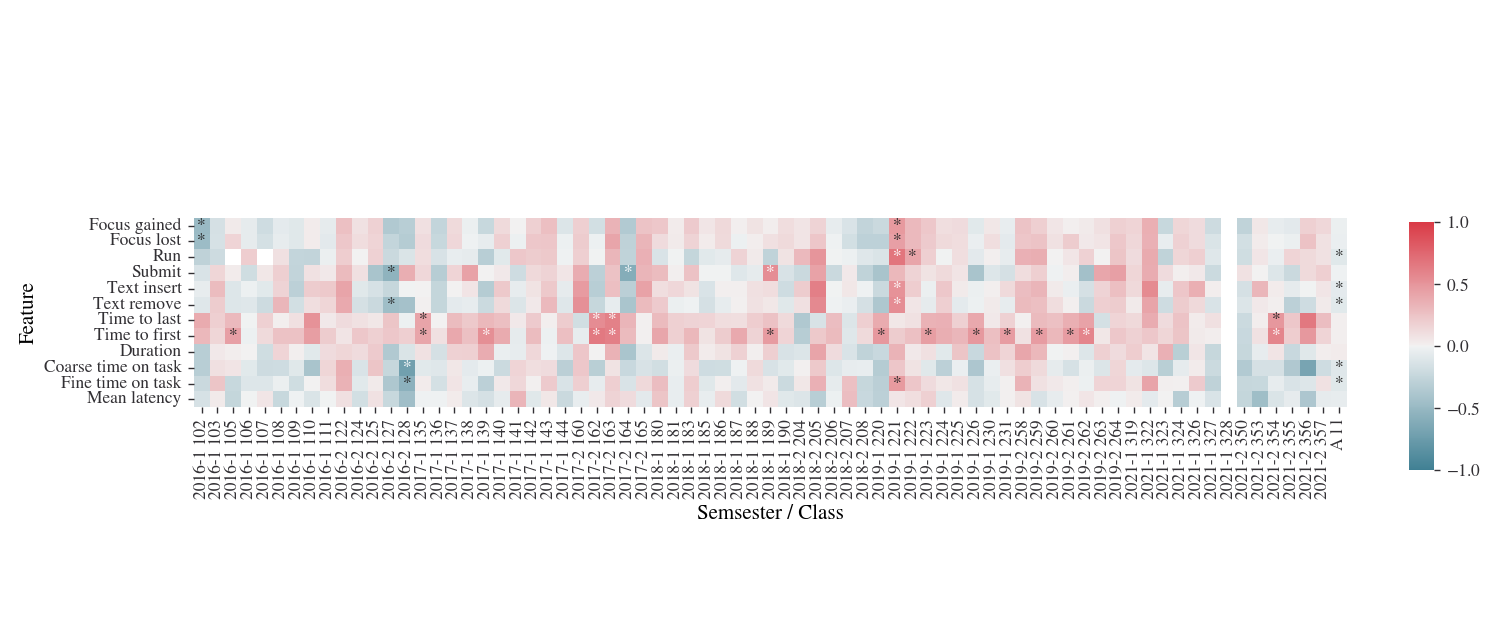

In [422]:
indexes = []
per_class_correlations = []
per_class_p = []
for (index, group), (_, grades_group) in zip(
    summary_features.groupby(['semester', 'class']), 
    grades.groupby(['semester', 'class'])
):
    try:
        data = group.assign(final=grades_group)
    except KeyError:
        pass
    corr = data.corr(method='spearman')['final']
    per_class_correlations.append(corr)
    per_class_p.append(data.corr(method=lambda x, y: stats.spearmanr(x,y)[1])['final'])
    indexes.append(index)

# Append vs all correlation & p value
per_class_correlations.append(summary_features.assign(final=grades).corr()['final'])
per_class_p.append(summary_features.assign(final=grades).corr(method=lambda x, y: stats.pearsonr(x,y)[1])['final'])
indexes.append('All')

per_class_correlations = pd.DataFrame(per_class_correlations, index=indexes).rename(lambda name: name.replace("_", " ").capitalize(), axis=1).T.iloc[:-1,]
per_class_p = pd.DataFrame(per_class_p, index=indexes).T.iloc[:-1,]

# Bonferroni correction
per_class_p_uncorrected = per_class_p
per_class_p = per_class_p.apply(lambda klass: multipletests(klass.to_numpy(), alpha=0.05, method='bonferroni')[1], axis=0)

annot = [[f"{'*' if r < 0.05 else ''}" for val, r in zip(row, q)] for row, q in zip(per_class_correlations.to_numpy(), per_class_p.to_numpy())]

plt.figure(figsize=(12,5))
ax = sns.heatmap(
    per_class_correlations,
    square=True, 
    cbar_kws={"orientation": "vertical", "fraction": 0.02, "aspect": 10, "anchor": (0., 0.4)},
    xticklabels=[" ".join(index) for index in indexes],
    vmin=-1.,
    vmax=1.,
    annot=annot,
    fmt='s',
    cmap=cmap
)
plt.xlabel("Semsester / Class")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig('figures/correlations_to_final_by_class.png', bbox_inches='tight')
plt.savefig('figures/correlations_to_final_by_class.pdf', bbox_inches='tight');

Fraction of classes with at least one significant correlation:

In [411]:
def fraction_significant_correlations(p, axis=0):
    has_significant = (p < 0.05).any(axis=axis)
    return np.count_nonzero(has_significant) / has_significant.shape[0]
fraction_significant_correlations(per_class_p)

0.2876712328767123

In [412]:
np.count_nonzero((per_class_p.loc['time_to_first'] < 0.05)[:-1])/71

0.19718309859154928

In [342]:
per_class_correlations

,"(2016-1, 102)","(2016-1, 103)","(2016-1, 105)","(2016-1, 106)","(2016-1, 107)","(2016-1, 108)","(2016-1, 109)","(2016-1, 110)","(2016-1, 111)","(2016-2, 122)",...,"(2021-1, 324)","(2021-1, 326)","(2021-1, 327)","(2021-2, 350)","(2021-2, 353)","(2021-2, 354)","(2021-2, 355)","(2021-2, 356)","(2021-2, 357)",All
focus_gained,-0.485234,-0.154722,0.045953,-0.060610,-0.188638,-0.065728,-0.093628,0.038596,-0.060134,0.269189,...,0.149693,0.122329,-0.200170,-0.269854,0.060635,-0.048418,-0.072284,0.182233,0.142347,-0.028552
focus_lost,-0.472617,-0.144751,0.159862,-0.057980,-0.158247,-0.051541,-0.093628,0.034226,-0.077224,0.233145,...,0.179201,0.121757,-0.121324,-0.168805,0.036560,-0.005400,-0.029604,0.259682,0.093008,-0.038404
run,-0.274010,-0.199008,NaN,0.198022,NaN,0.098880,-0.257372,-0.258199,-0.024275,0.196343,...,0.155764,0.190057,-0.095925,-0.182170,0.065050,-0.036503,0.157230,0.132119,0.092948,-0.088786
submit,-0.132353,0.153223,0.035422,-0.181843,0.058024,0.190055,-0.261858,0.091509,0.053854,0.303941,...,0.015953,0.049349,-0.204925,0.086564,0.001543,-0.106393,-0.216092,0.130137,0.193559,-0.015308
text_insert,-0.051068,0.291739,-0.103004,-0.022382,-0.081817,0.168546,-0.294805,0.207018,0.225100,0.423478,...,0.239525,0.365603,0.029395,-0.151183,0.322816,0.031652,-0.055290,-0.004556,0.066298,-0.069193
text_remove,-0.096241,0.204950,-0.103494,-0.098153,-0.198660,0.322662,-0.166342,0.101754,0.150500,0.396522,...,0.203496,0.135509,-0.130090,-0.115516,0.053877,0.019550,-0.291685,-0.191344,0.045499,-0.079360
time_to_last,0.383565,0.188493,0.310596,-0.000720,0.184707,0.021294,0.100000,0.522807,0.048250,0.120000,...,0.253559,0.033737,0.098898,-0.206021,0.026933,0.497688,0.232913,0.660594,0.284693,0.016139
time_to_first,0.314406,0.155566,0.449920,-0.017338,0.131832,0.264220,0.261039,0.454386,0.204402,0.076522,...,0.245540,0.043271,0.029952,-0.225360,0.092343,0.587432,0.201567,0.492029,0.156646,0.020181
duration,-0.319918,0.048809,0.023868,0.003890,-0.182691,0.159148,0.016883,-0.080702,0.120512,0.152174,...,-0.309407,0.068574,-0.238553,-0.238510,-0.048095,0.073918,-0.225512,-0.091116,0.027299,0.034606
coarse_time_on_task,-0.317732,0.097637,0.071874,-0.080309,-0.198696,-0.194452,-0.093506,-0.400000,0.154264,0.363478,...,-0.055325,0.032270,-0.205201,-0.349385,-0.155829,-0.150628,-0.363083,-0.678817,-0.191808,-0.100268


In [340]:
per_class_p

,"(2016-1, 102)","(2016-1, 103)","(2016-1, 105)","(2016-1, 106)","(2016-1, 107)","(2016-1, 108)","(2016-1, 109)","(2016-1, 110)","(2016-1, 111)","(2016-2, 122)",...,"(2021-1, 324)","(2021-1, 326)","(2021-1, 327)","(2021-2, 350)","(2021-2, 353)","(2021-2, 354)","(2021-2, 355)","(2021-2, 356)","(2021-2, 357)",All
focus_gained,0.004916,1.000000,1.000000,1.0,1.0,1.00000,1.0,1.000000,1.0,1.000000,...,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000
focus_lost,0.007270,1.000000,1.000000,1.0,1.0,1.00000,1.0,1.000000,1.0,1.000000,...,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,0.611820
run,0.681061,1.000000,NaN,1.0,NaN,1.00000,1.0,1.000000,1.0,1.000000,...,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,0.000075
submit,1.000000,1.000000,1.000000,1.0,1.0,1.00000,1.0,1.000000,1.0,1.000000,...,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000
text_insert,1.000000,0.349637,1.000000,1.0,1.0,1.00000,1.0,1.000000,1.0,0.470447,...,1.000000,0.475392,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,0.005196
text_remove,1.000000,1.000000,1.000000,1.0,1.0,0.70432,1.0,1.000000,1.0,0.660821,...,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,0.000648
time_to_last,0.078206,1.000000,0.427841,1.0,1.0,1.00000,1.0,0.259643,1.0,1.000000,...,1.000000,1.000000,1.0,1.000000,1.000000,0.045012,1.000000,0.323093,1.0,1.000000
time_to_first,0.333552,1.000000,0.020472,1.0,1.0,1.00000,1.0,0.607820,1.0,1.000000,...,1.000000,1.000000,1.0,1.000000,1.000000,0.004897,1.000000,1.000000,1.0,1.000000
duration,0.300414,1.000000,1.000000,1.0,1.0,1.00000,1.0,1.000000,1.0,1.000000,...,0.624518,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,0.944027
coarse_time_on_task,0.313213,1.000000,1.000000,1.0,1.0,1.00000,1.0,1.000000,1.0,0.969944,...,1.000000,1.000000,1.0,0.440861,1.000000,1.000000,0.974211,0.259639,1.0,0.000004


In [413]:
per_class_correlations.T.max()

focus_gained           0.484362
focus_lost             0.452692
run                    0.673479
submit                 0.542157
text_insert            0.619863
text_remove            0.564197
time_to_last           0.660594
time_to_first          0.653885
duration               0.429423
coarse_time_on_task    0.363478
fine_time_on_task      0.480433
mean_latency           0.329998
dtype: float64

In [414]:
per_class_correlations.T.abs().min()

focus_gained           0.004943
focus_lost             0.005400
run                    0.000198
submit                 0.001543
text_insert            0.002095
text_remove            0.008062
time_to_last           0.000207
time_to_first          0.009023
duration               0.000877
coarse_time_on_task    0.008832
fine_time_on_task      0.007018
mean_latency           0.000000
dtype: float64

In [415]:
per_class_correlations.T.min()

focus_gained          -0.485234
focus_lost            -0.472617
run                   -0.314472
submit                -0.594669
text_insert           -0.335655
text_remove           -0.458339
time_to_last          -0.361895
time_to_first         -0.325820
duration              -0.393283
coarse_time_on_task   -0.713258
fine_time_on_task     -0.561665
mean_latency          -0.460562
dtype: float64

In [420]:
per_class_correlations.loc['time_to_first'].abs().min()

0.009022556390977444

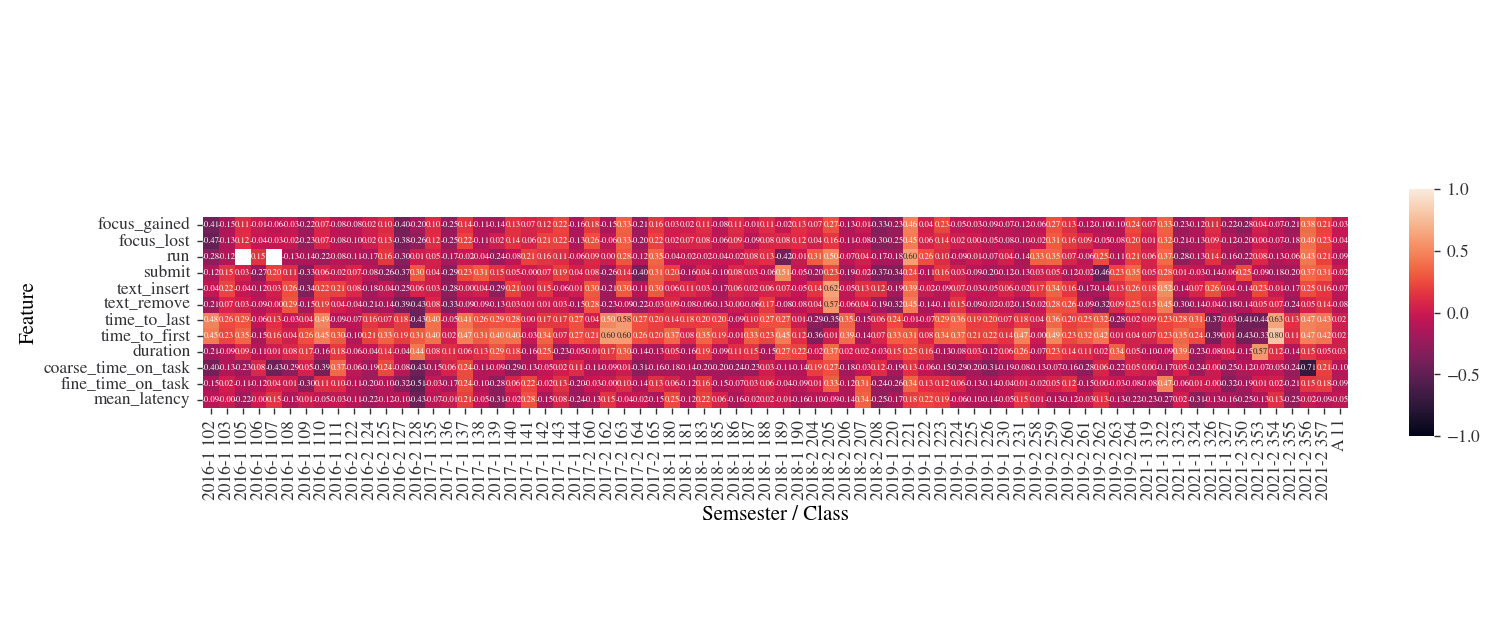

In [268]:
indexes = []
per_class_correlations = []
for (index, group), (_, grades_group) in zip(summary_features.groupby(['semester', 'class']), grades.groupby(['semester', 'class'])):
    try:
        data = group.assign(final=grades_group)
    except KeyError:
        pass
    corr = data.corr()['final']
    per_class_correlations.append(corr)
    indexes.append(index)
    
per_class_correlations.append(summary_features.assign(final=grades).corr()['final'])
indexes.append('All')
    
per_class_correlations = pd.DataFrame(per_class_correlations, index=indexes)
plt.figure(figsize=(12,5))
ax = sns.heatmap(
    per_class_correlations.T.iloc[:-1], 
    square=True, 
    cbar_kws={"orientation": "vertical", "fraction": 0.02, "aspect": 10},
    xticklabels=[" ".join(index) for index in indexes],
    vmin=-1.,
    vmax=1.,
    annot=True,
    fmt='.2f',
    annot_kws={"size": 5}
)
plt.xlabel("Semsester / Class")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig('figures/correlations_to_final_by_class.png', bbox_inches='tight')
plt.savefig('figures/correlations_to_final_by_class.pdf', bbox_inches='tight');

In [259]:
np.count_nonzero(per_class_correlations.iloc[:-1,:-5].max(axis=1) > 0.2) / 70

0.8

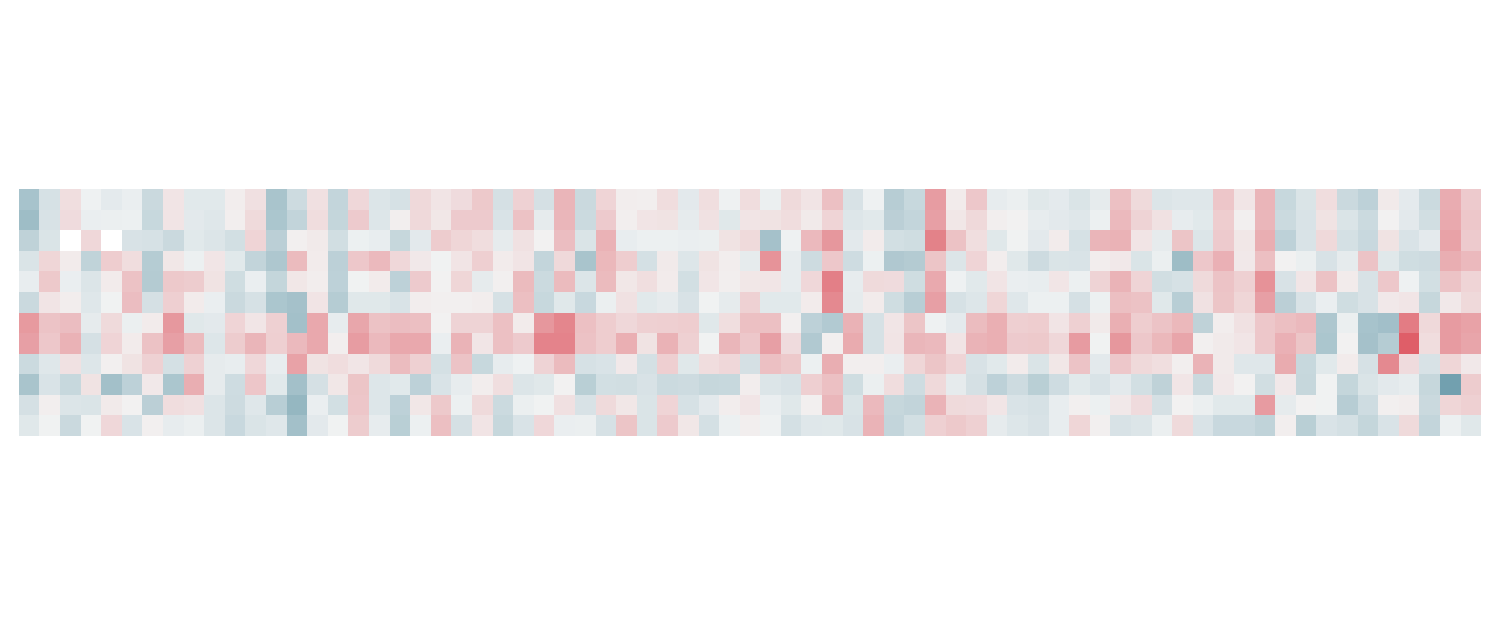

In [347]:
indexes = []
per_class_correlations = []
for (index, group), (_, grades_group) in zip(summary_features.groupby(['semester', 'class']), grades.groupby(['semester', 'class'])):
    try:
        data = group.assign(final=grades_group)
    except KeyError:
        pass
    corr = data.corr()['final']
    per_class_correlations.append(corr)
    indexes.append(index)
per_class_correlations = pd.DataFrame(per_class_correlations, index=indexes)
plt.figure(figsize=(12,5))
ax = sns.heatmap(
    per_class_correlations.T.iloc[:-1], 
    square=True, 
    cbar_kws={"orientation": "vertical", "fraction": 0.02, "aspect": 10},
    xticklabels=[" ".join(index) for index in indexes][:-6],
    vmin=-1.,
    vmax=1.,
    cbar=False,
    cmap=cmap
)
plt.xticks([])
plt.yticks([])
#plt.xlabel("Semsester / Class")
#plt.ylabel("Feature")
plt.tight_layout()
plt.savefig('figures/abstract.png', bbox_inches='tight')
plt.savefig('figures/abstract.pdf', bbox_inches='tight')

### Per semester

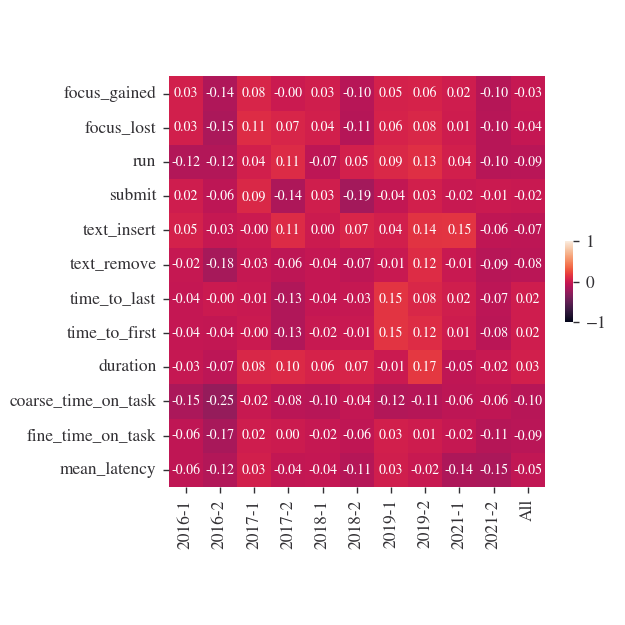

In [248]:
indexes = []
per_class_correlations = []
for (index, group), (_, grades_group) in zip(summary_features.groupby(['semester']), grades.groupby(['semester'])):
    try:
        data = group.assign(final=grades_group)
    except KeyError:
        pass
    corr = data.corr()['final']
    per_class_correlations.append(corr)
    indexes.append(index)
    
per_class_correlations.append(summary_features.assign(final=grades).corr()['final'])
indexes.append('All')
    
per_class_correlations = pd.DataFrame(per_class_correlations, index=indexes)
plt.figure(figsize=(5,5))
ax = sns.heatmap(
    per_class_correlations.T.iloc[:-1], 
    square=True, 
    cbar_kws={"orientation": "vertical", "fraction": 0.02, "aspect": 10},
    xticklabels=["".join(index) for index in indexes],
    vmin=-1.,
    vmax=1.,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8}
)
plt.tight_layout()
plt.savefig('figures/correlations_to_final_by_semester.png', bbox_inches='tight')
plt.savefig('figures/correlations_to_final_by_semester.pdf', bbox_inches='tight');

### Questions

2. On the MDS and PCA plots there are some outliers, most of which perform poorly
   * In what counts were they abnormal?
   * Could this indicate cheating/plagiarism? 

### Outlier investigation

In [24]:
outliers = reduced_mds[:,1]<-2.*10**4

Normal values:

In [25]:
keystroke_counts.mean()

focus_gained     531.937639
focus_lost       513.400891
run              163.777283
submit            32.383073
text_insert     6226.897550
text_paste        58.483296
text_remove     1891.621381
dtype: float64

Outlier values:

In [26]:
keystroke_counts[outliers]

,focus_gained,focus_lost,run,submit,text_insert,text_paste,text_remove
student,,,,,,,
0,335.0,327.0,94.0,30.0,4744.0,59.0,1068.0
1,327.0,325.0,205.0,37.0,7050.0,45.0,1878.0
2,711.0,672.0,161.0,31.0,4660.0,80.0,894.0
3,100.0,89.0,0.0,30.0,284.0,28.0,156.0
5,395.0,379.0,72.0,0.0,1995.0,8.0,766.0
...,...,...,...,...,...,...,...
436,489.0,479.0,118.0,36.0,4213.0,102.0,1349.0
438,469.0,439.0,134.0,30.0,9056.0,100.0,1617.0
440,219.0,202.0,19.0,32.0,2764.0,63.0,565.0


Relative:

In [27]:
keystroke_counts[outliers]-keystroke_counts.mean().round()

,focus_gained,focus_lost,run,submit,text_insert,text_paste,text_remove
student,,,,,,,
0,-197.0,-186.0,-70.0,-2.0,-1483.0,1.0,-824.0
1,-205.0,-188.0,41.0,5.0,823.0,-13.0,-14.0
2,179.0,159.0,-3.0,-1.0,-1567.0,22.0,-998.0
3,-432.0,-424.0,-164.0,-2.0,-5943.0,-30.0,-1736.0
5,-137.0,-134.0,-92.0,-32.0,-4232.0,-50.0,-1126.0
...,...,...,...,...,...,...,...
436,-43.0,-34.0,-46.0,4.0,-2014.0,44.0,-543.0
438,-63.0,-74.0,-30.0,-2.0,2829.0,42.0,-275.0
440,-313.0,-311.0,-145.0,0.0,-3463.0,5.0,-1327.0


In [28]:
grades[outliers]

,part1,part2,part3,part4,part5,part6,part7,exam1,exam2,exam3,final
student,,,,,,,,,,,
0,0.9,1.0,0.7,0.2,0.7,0.0,0.0,1.0,0.0,0.0,0.371
1,1.0,0.9,0.8,1.0,0.9,0.9,0.9,1.0,0.8,0.5,0.822
2,1.0,1.0,1.0,0.9,1.0,1.0,0.9,1.0,0.9,1.0,0.969
3,1.0,1.0,1.0,1.0,1.0,0.5,0.0,1.0,1.0,0.0,0.680
5,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028
...,...,...,...,...,...,...,...,...,...,...,...
436,0.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063
438,1.0,1.0,1.0,1.0,1.0,1.0,0.9,1.0,1.0,0.9,0.972
440,1.0,1.0,1.0,1.0,1.0,1.0,0.9,1.0,0.8,0.7,0.902


The main thing that stands out is 'more events'. In particular student 39 ran code 1300 times, compared to the mean of 164 times.

## HMM

Prior work has proposed designed state models based on various events sourced from programming activity.

As an alternative to these designed models we experiment with a HMM trained on each student. The parameters of this HMM (start state, transition probabilities, emission probabilities) are used as the input to a regressor (a support vector regressor or random forest regressor).

In [77]:
train_ids, test_ids = train_test_split(keystrokes.index.unique(), test_size=0.5, stratify=grades.exam3)

In [33]:
encoder = LabelEncoder()
encoder.fit(list(keystrokes.event_type.value_counts().index))

LabelEncoder()

In [22]:
X = []
for studentid, student_keystrokes in tqdm(keystrokes.groupby(keystrokes.index)):
    model = hmm.GaussianHMM(n_components=5)
    model.fit(
        encoder.transform(student_keystrokes.event_type.to_numpy()).reshape(-1, 1),
        student_keystrokes.groupby("exercise").apply(lambda x: x.shape[0]).to_numpy()
    )
    params = np.concatenate((model.startprob_, model.transmat_.reshape(-1), model.means_.reshape(-1), model.covars_.reshape(-1)))
    X.append(params)
X = np.array(X)

### SVM

In [22]:
clf = SVR()
clf.fit(X[train_ids], grades.exam3[train_ids])
predicted = clf.predict(X[test_ids])
r2_score(grades.exam3[test_ids], predicted)

NameError: name 'X' is not defined

### Random Forest

In [23]:
clf = RandomForestRegressor(n_jobs=-1)
clf.fit(X[train_ids], grades.exam3[train_ids])
predicted = clf.predict(X[test_ids])
r2_score(grades.exam3[test_ids], predicted)

NameError: name 'X' is not defined

In [24]:
@interact(feat=widgets.Dropdown(options=list(range(X.shape[1])), value=np.argmax(clf.feature_importances_)))
def plot_residuals(feat):
    plt.scatter(X[test_ids, feat], predicted-grades.exam3[test_ids])
    plt.axhline(0, ls='--', color='grey')

NameError: name 'X' is not defined

## SKTime

Time based classifiers and clustering algorithms.

### Old

In [12]:
keystrokes_np = list(ks.to_numpy() for student, ks in keystrokes.groupby(keystrokes.index))
for i in tqdm(range(len(keystrokes_np)), total=len(keystrokes_np)):
    keystrokes_np[i][:,0] = encoder.transform(keystrokes_np[i][:,0].reshape(-1,1))
    keystrokes_np[i] = np.delete(keystrokes_np[i], 1, axis=1)
    keystrokes_np[i] = np.c_[keystrokes_np[i][:,1], keystrokes_np[i][:,0]]
    keystrokes_np[i] = np.pad(keystrokes_np[i], [(0, 55750-keystrokes_np[i].shape[0]), (0,0)])
#keystrokes_np

In [14]:
np.array(keystrokes_np).shape

(449, 55750, 2)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(np.array(keystrokes_np), grades.final)
classifier = ComposableTimeSeriesForestRegressor(n_jobs=-1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy_score(y_test, y_pred)

ValueError: X must be univariate with X.shape[1] == 1, but found: X.shape[1] == 55750.

In [26]:
from sktime.datasets import load_arrow_head

In [33]:
load_arrow_head()[0].iloc[0]

dim_0    0     -1.963009
1     -1.957825
2     -1.95614...
Name: 0, dtype: object

In [29]:
load_arrow_head()[1]

array(['0', '1', '2', '0', '1', '2', '0', '1', '2', '0', '1', '2', '0',
       '1', '2', '0', '1', '2', '0', '1', '2', '0', '1', '2', '0', '1',
       '2', '0', '1', '2', '0', '1', '2', '0', '1', '2', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2',
       '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2

### New

In [84]:
index = pd.MultiIndex.from_arrays([keystrokes.index, keystrokes.time_to_deadline.max()-keystrokes.time_to_deadline])

In [85]:
keystrokes_sktime = pd.DataFrame(encoder.transform(keystrokes.event_type), index)

## Summary Classification

In [29]:
grades = grades[~grades.grade.isna()]
keystrokes = keystrokes[keystrokes.index.isin(grades.index)]

In [30]:
train_ids, test_ids = train_test_split(keystrokes.index.unique(), test_size=0.5)

In [31]:
encoder = LabelEncoder()
encoder.fit(list(keystrokes.event_type.value_counts().index))

LabelEncoder()

In [39]:
summary_features_norm = Normalizer().fit_transform(summary_features)

In [32]:
summary_train = summary_features[summary_features.index.isin(train_ids)]
summary_test = summary_features[summary_features.index.isin(test_ids)]
grades_train = grades.grade[grades.index.isin(train_ids)]
grades_test = grades.grade[grades.index.isin(test_ids)]

In [48]:
clf = RandomForestRegressor()
clf.fit(summary_train, grades_train)
predicted = clf.predict(summary_test)
r2_score(grades_test, predicted)

0.06647170607802677

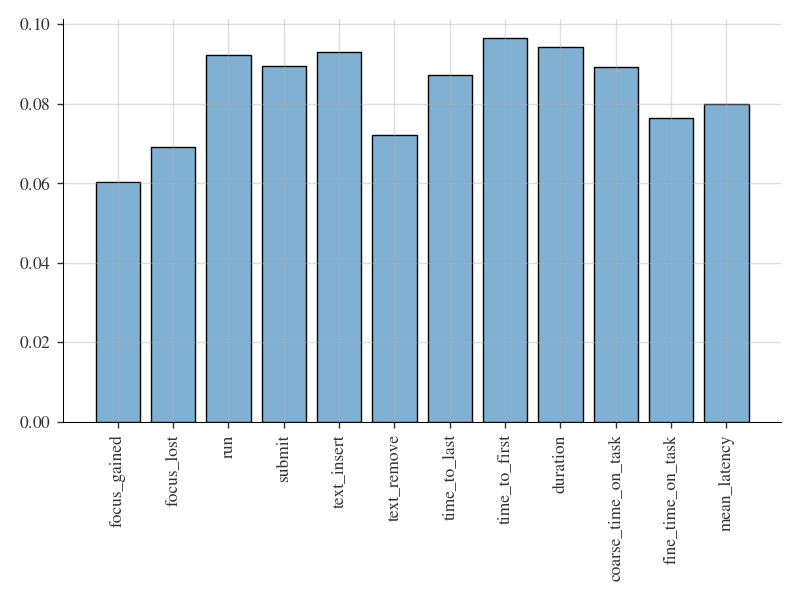

In [49]:
plt.figure()
plt.bar(summary_features.columns, clf.feature_importances_)
plt.xticks(rotation='vertical')
plt.grid(alpha=0.4)
plt.tight_layout();

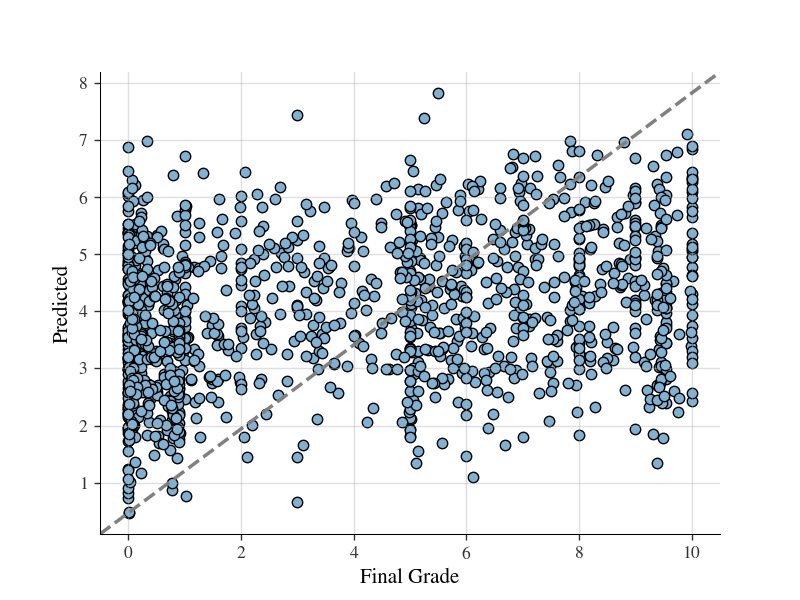

In [51]:
plt.figure()
plt.scatter(grades_test, predicted)
plt.xlabel("Final Grade")
plt.ylabel("Predicted")
plt.grid(alpha=0.4)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='grey', ls='--');

### Normalised

In [40]:
summary_train_norm = summary_features_norm[summary_features.index.isin(train_ids)]
summary_test_norm = summary_features_norm[summary_features.index.isin(test_ids)]

In [52]:
clf = RandomForestRegressor()
clf.fit(summary_train, grades_train)
predicted = clf.predict(summary_test)
r2_score(grades_test, predicted)

0.07397303343185824

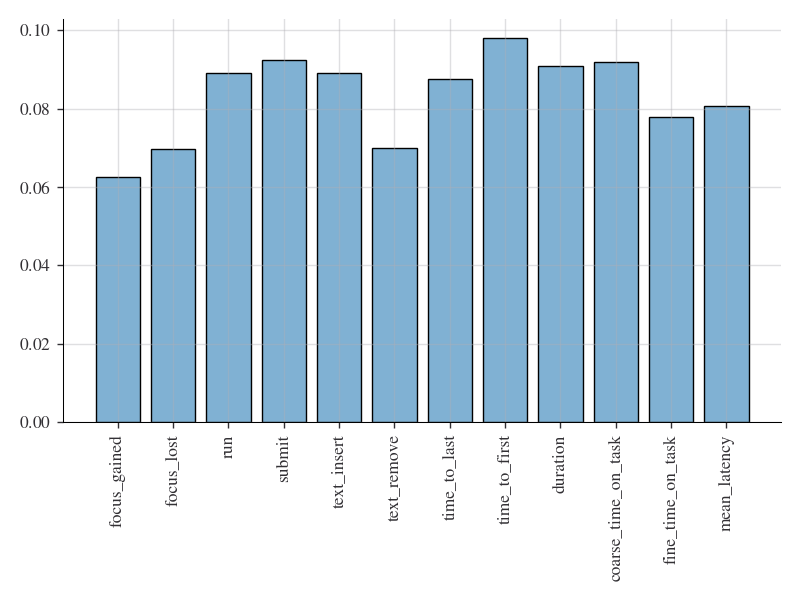

In [53]:
plt.figure()
plt.bar(summary_features.columns, clf.feature_importances_)
plt.xticks(rotation='vertical')
plt.grid(alpha=0.4)
plt.tight_layout();

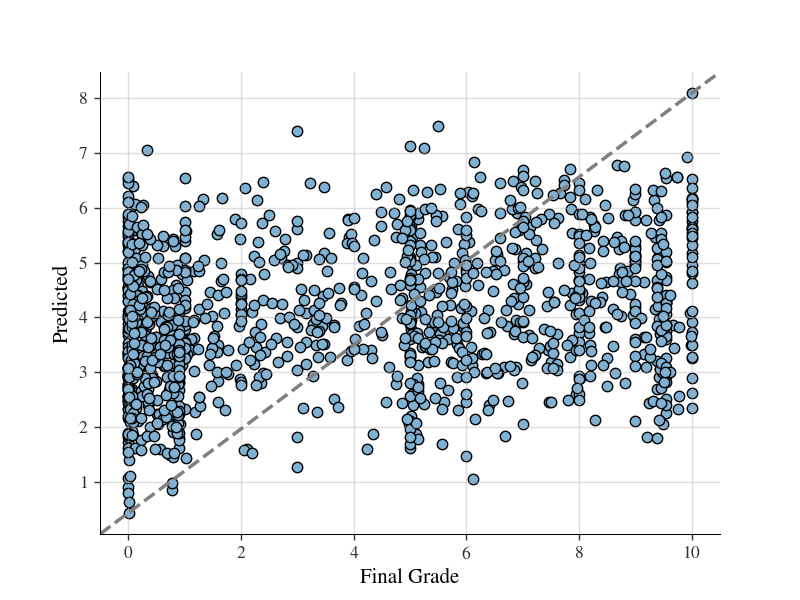

In [54]:
plt.figure()
plt.scatter(grades_test, predicted)
plt.xlabel("Final Grade")
plt.ylabel("Predicted")
plt.grid(alpha=0.4)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='grey', ls='--');

## Regression CV

In [209]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

In [230]:
summary_features = summary_features[summary_features.index.isin(grades.index)]

In [372]:
len([x[1] for x in summary_features.groupby(summary_features.index.get_level_values(0))][:-1])

9

In [376]:
@interact(
    summary_features=widgets.fixed(summary_features),
    grades=widgets.fixed(grades),
    model=widgets.Dropdown(options=[partial(RandomForestRegressor, random_state=42), LinearRegression]),
    split=widgets.Dropdown(options=['train_test_sem_1', '5fold_sem_1', '5fold_sem_2', '2sem', 'rolling'], value='2sem'),
    target=widgets.Dropdown(options=grades.columns, value='grade'),
    plot_importance=False,
    plot_scatter=False,
    norm=False,
    random_state=42
)
def evaluate_regression(summary_features, grades, model, split, plot_importance, norm, plot_scatter, target, random_state, silent=False):
    
    features = pd.DataFrame(Normalizer().fit_transform(summary_features), index=summary_features.index) if norm else summary_features
    
    if split == 'train_test_sem_1' or split == 'train_test_sem_2':
        train_ids, test_ids = train_test_split(keystrokes.loc[1].index.unique(), test_size=0.5, random_state=random_state)
        summary_train = [features.loc[sem][features.loc[sem].index.isin(train_ids)]]
        summary_test = [features.loc[sem][features.loc[sem].index.isin(test_ids)]]
        grades_train = [grades[target].loc[sem][grades.loc[sem].index.isin(train_ids)]]
        grades_test = [grades[target].loc[sem][grades.loc[sem].index.isin(test_ids)]]
    elif split == '5fold_sem_1' or split == '5fold_sem_2':
        train_ids, test_ids = train_test_split(keystrokes.index.unique(), test_size=0.5, random_state=random_state)
        folds = KFold(random_state=42, shuffle=True)
        summary_train = []
        summary_test = []
        grades_train = []
        grades_test = []
        for train_ids, test_ids in folds.split(features):
            print(train_ids)
            summary_train_ = features.iloc[train_ids]
            summary_test_ = features.iloc[test_ids]
            grades_train_ = grades[target].iloc[train_ids]
            grades_test_ = grades[target].iloc[test_ids]
        
            summary_train.append(summary_train_)
            summary_test.append(summary_test_)
            grades_train.append(grades_train_)
            grades_test.append(grades_test_)
    elif split == '2sem':
        # some features not available in sem 2 so we filter them out of our training data
        #sem_2_cols = ['run', 'submit', 'text_insert', 'text_remove', 'time_to_last', 'time_to_first', 'duration', 'coarse_time_on_task', 'fine_time_on_task', 'mean_latency']
        train_semesters = ['2016-1', '2016-2', '2017-1', '2017-2', '2018-1', '2018-2', '2019-1', '2019-2']
        test_semesters = ['2021-1', '2021-2']
        summary_train = [summary_features.loc[train_semesters]]
        summary_test = [summary_features.loc[test_semesters]]
        grades_train = [grades.grade.loc[train_semesters]]
        grades_test = [grades.grade.loc[test_semesters]]
    elif split == 'rolling':
        summary_train = [x[1] for x in summary_features.groupby(summary_features.index.get_level_values(0))][:-1]
        summary_test = [x[1] for x in summary_features.groupby(summary_features.index.get_level_values(0))][1:]
        grades_train = [x[1].grade for x in grades.groupby(grades.index.get_level_values(0))][:-1]
        grades_test = [x[1].grade for x in grades.groupby(grades.index.get_level_values(0))][1:]
                
    r2s = []
    adj_r2s = []
    for summary_train_, summary_test_, grades_train_, grades_test_ in zip(summary_train, summary_test, grades_train, grades_test):
        clf = model()
        clf.fit(summary_train_, grades_train_)
        predicted = clf.predict(summary_test_)
        r2 = r2_score(grades_test_, predicted)
        adj_r2 = 1-(1-r2)*(summary_test_.shape[0]-1)/(summary_test_.shape[0]-summary_test_.shape[1]-1)
        r2s.append(r2)
        adj_r2s.append(adj_r2)
        
        if not silent:
            print(f"adjusted r^2 {adj_r2}")
    
    if plot_importance:
        plt.figure()
        plt.bar(summary_train.columns, clf.feature_importances_)
        plt.xticks(rotation='vertical')
        plt.grid(alpha=0.4)
        plt.tight_layout()
        plt.show()
        
    if plot_scatter:
        plt.figure()
        plt.scatter(predicted, grades_test)
        plt.xlabel("Predicted")
        plt.ylabel("Final Grade")
        plt.grid(alpha=0.4)
        plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='grey', ls='--')
        plt.show()
    
    return np.mean(r2s), np.mean(adj_r2s)

interactive(children=(Dropdown(description='model', options=(functools.partial(<class 'sklearn.ensemble._fores…

## Bootstrap

In [ ]:
@interact(
    summary_features=widgets.fixed(summary_features),
    grades=widgets.fixed(grades),
    model=widgets.Dropdown(options=[partial(RandomForestRegressor, random_state=42), LinearRegression]),
    split=widgets.Dropdown(options=['train_test_sem_1', 'train_test_sem_2', '5fold_sem_1', '5fold_sem_2', '2sem']),
    target=widgets.Dropdown(options=grades.columns, value='final'),
    plot_importance=False,
    plot_scatter=False,
    norm=False,
    count=widgets.IntSlider(min=100,max=2000, step=100, value=100)
)
def bootstrap_regression(summary_features, grades, model, split, plot_importance, norm, plot_scatter, target, count=100):
    r2 = []
    for i in range(count):
        mask = np.random.choice(summary_features.shape[0], size=summary_features.shape[0], replace=True)
        X = summary_features.iloc[mask]
        y = grades.iloc[mask]
        raw_r2, adj_r2 = evaluate_regression(X, y, model, split, plot_importance, norm, plot_scatter, target, random_state=i, silent=True)
        r2.append(adj_r2)
    plt.figure()
    plt.hist(r2)
    plt.axvline(np.mean(r2), ls='--', color='grey')
    print("mean", np.mean(r2))
    print("std", np.std(r2))
    print("lower", np.quantile(r2, .025))
    print("upper", np.quantile(r2, .975))
    plt.xlabel('adjusted r^2')
    plt.ylabel('Count')
    plt.grid(alpha=0.4)
    plt.show()

In [381]:
import types; from math import ceil

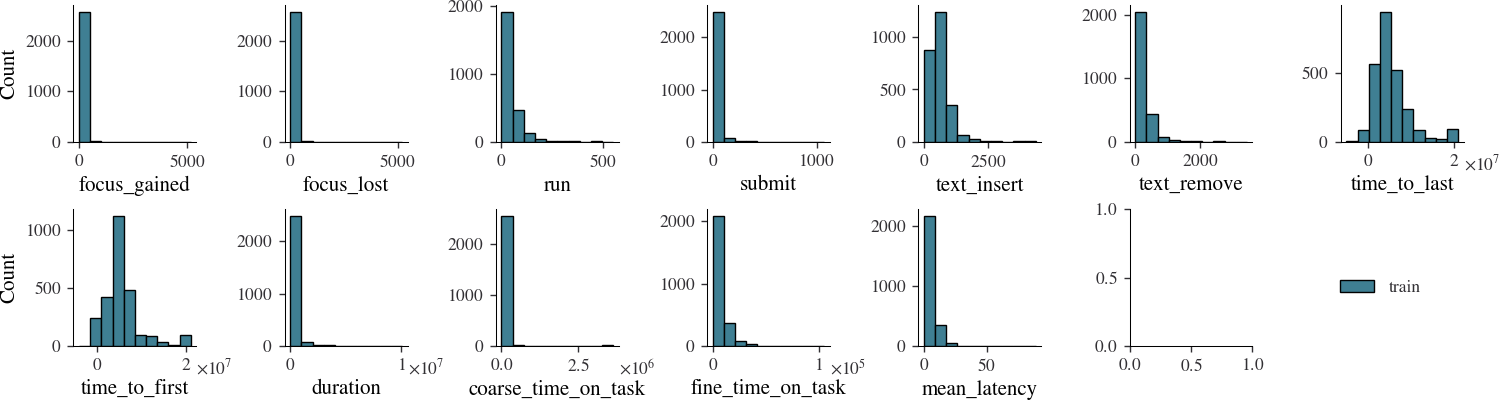

In [382]:
pad = plt.rcParams["xtick.major.size"] + plt.rcParams["xtick.major.pad"]
def bottom_offset(self, bboxes, bboxes2):
    bottom = self.axes.bbox.ymin
    self.offsetText.set(va="top", ha="left") 
    oy = bottom - pad * self.figure.dpi / 72.0
    self.offsetText.set_position((1, oy))

fig, axes = plt.subplots(ceil(len(summary_features.columns) / 7), 7, figsize=(12,3.2))
#for (name, semester), color in zip(summary_features.groupby('semester'), [cmap(0), cmap(255)]):
name = 1
semester = summary_features
color = cmap(0)
for i, ((feature, data), ax) in enumerate(zip(semester.iteritems(), axes.flatten())):
    label = "train" if name == 1 else "test"
    ax.hist(data, label=label if i == 0 else None, color=color)
    ax.set_xlabel(feature)
    if i % 7 == 0:
        ax.set_ylabel("Count")
    ax.xaxis._update_offset_text_position = types.MethodType(bottom_offset, ax.xaxis)
axes[-1][-1].set_visible(False)

fig.legend(loc='center', bbox_to_anchor=(0.92,0.28), frameon=False)
fig.tight_layout(pad=0, h_pad=0.5, w_pad=0.2)
fig.savefig('figures/hist_semester_comp_large.png', bbox_inches='tight')
fig.savefig('figures/hist_semester_comp_large.pdf', bbox_inches='tight');

In [383]:
import pickle

In [384]:
with open("large_summary_features.pickle", "wb") as f:
    pickle.dump(summary_features, f)